# Machine Learning Project

## Introduction

The goal of the project is to recognize if the image is a face or not.

Images are greyscale 36x36 pixels images.

To reach the goal, we will try to train a convolutional neural network.

In [1]:
from deep_learning_project.load_data import load
from deep_learning_project.net import FirstNeuralNetwork
import torch
import matplotlib.pyplot as plt
from torch import nn
from deep_learning_project.trainers import BaseTrainer

## Data

Data is separated in 3 datasets.

Train : to train the ML model.

Valid : to valid the ML model.

Test : to test the ML model.

What is the difference between valid and test datasets. The main differencec is when there are used : valid are used inside the training process but test are used when the training is complete. Why use different datasets to do the same thing (test the generalization of model) ? Some do the validation with the test dataset but it is not scientifically correct because it will include a bias on the model. If we train the model until the test dataset error is the lowest, we effectively train the model for the test dataset... This is why we use two different dataset.

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
valid_size = 0.2
batch_size = 32

print(f"Running on {device}.")

data = load(valid_size=valid_size, batch_size=batch_size, device=device)
train_loader = data[0]
valid_loader = data[1]
test_loader = data[2]
classes = data[3]

Running on cuda.


Printing one image of the training set.


Feature batch shape: torch.Size([32, 1, 36, 36])
Labels batch shape: torch.Size([32])


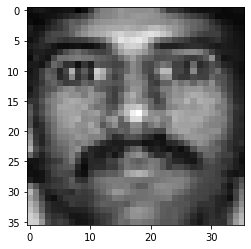

Label: 1


In [3]:
train_features, train_labels = next(iter(data[0]))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze() # from 2d to 1d, works only when the data is 1d [[x]] => [x]
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()

print(f"Label: {label}")

## Initializing the FirstNeuralNetwork network

We initialize the network.

Print the configuration.

Then predict a random input.

---

FirstNeuralNetwork is the neural network given by the teacher.

In [4]:
model = FirstNeuralNetwork().to(device)
# print(model)

random_shit = torch.rand((1, 1, 36, 36), device=device)

logits = model(random_shit)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([0], device='cuda:0')


## Optimizing the network

In [6]:
epochs = 50
learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
trainer = BaseTrainer(model, loss_fn, optimizer)

In [7]:
trainer.fit(train_loader=train_loader,
            test_loader=test_loader,
            epochs=epochs,
            device=device)

Epoch 1
-------------------------------
loss: 0.760158  [    0/91720]
loss: 0.695784  [32768/91720]
loss: 0.554281  [65536/91720]
Test Error: 
 Accuracy: 10.4%, Avg loss: 0.943738 

Epoch 2
-------------------------------
loss: 0.621058  [    0/91720]
loss: 0.485413  [32768/91720]
loss: 0.276336  [65536/91720]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.660436 

Epoch 3
-------------------------------
loss: 0.368356  [    0/91720]
loss: 0.361327  [32768/91720]
loss: 0.261046  [65536/91720]
Test Error: 
 Accuracy: 83.6%, Avg loss: 0.441525 

Epoch 4
-------------------------------
loss: 0.165099  [    0/91720]
loss: 0.117774  [32768/91720]
loss: 0.192987  [65536/91720]
Test Error: 
 Accuracy: 84.9%, Avg loss: 0.418412 

Epoch 5
-------------------------------
loss: 0.046761  [    0/91720]
loss: 0.214798  [32768/91720]
loss: 0.200076  [65536/91720]
Test Error: 
 Accuracy: 85.9%, Avg loss: 0.402882 

Epoch 6
-------------------------------
loss: 0.103574  [    0/91720]
loss: 0.030351  [327

KeyboardInterrupt: 

In [ ]:
# save model
# torch.save(model, 'model.pt')

In [ ]:
# load model
# ld_model = torch.load('model.pt')

# test_loop(test_loader, ld_model, loss_fn)

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.318500 

